In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Load Libraries

In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    make_scorer, 
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    median_absolute_error
)

import warnings
warnings.filterwarnings(action='ignore')

### Functions

In [2]:
def median_absolute_percentage_error(actual, pred):
    errors = np.abs(pred - actual) / actual
    mdape = np.nanmedian(errors)
    return mdape

def mean_absolute_percentage_error(actual, pred):
    errors = np.abs(pred - actual) / actual
    mape = np.nanmean(errors)
    return mape

def median_absolute_percentage_error_95(actual, pred):
    errors = np.abs(pred - actual) / actual
    quantile_filter = errors < np.nanquantile(errors, .95)
    mdape95 = np.nanmedian(errors[quantile_filter])
    return mdape95

def mean_absolute_percentage_error_95(actual, pred):
    errors = np.abs(pred - actual) / actual
    quantile_filter = errors < np.nanquantile(errors, .95)
    mape95 = np.nanmean(errors[quantile_filter])
    return mape95

def avm_metrics_all(actual, pred, inv_transform=None):
    '''
    Takes actual and predicted target values to compute common 
    cross validation metrics including MAPE, MAPE95, MdAPE, MdAPE95.

    Parameters
    ----------
    actual : array-like
        Ground truth target values.

    pred : array-like
        Predicted target values.

    inv_transform : Function (Optional)
        A user defined function that performs the inverse mapping
        if a transformation has been applied to the target value.
        E.g. np.log and np.exp.

    Returns
    ----------
    metrics : dict
        Returns the evaluated metrics as a dictionary.
    '''
    if (actual.shape != pred.shape):
        raise ValueError(f'{actual.shape} and {pred.shape} not aligned')

    if inv_transform:
        assert isinstance(inv_transform, np.ufunc), \
            'inv_transform function should be of type np.ufunc'
        actual = inv_transform(actual)
        pred = inv_transform(pred)
    
    metrics = {'MAPE': round(mean_absolute_percentage_error(actual, pred)*100, 2), 
                'MAPE95': round(mean_absolute_percentage_error_95(actual, pred)*100, 2), 
                'MdAPE': round(median_absolute_percentage_error(actual, pred)*100, 2), 
                'MdAPE95': round(median_absolute_percentage_error_95(actual, pred)*100, 2)}
    
    return metrics

def produce_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rtwo = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mdape = median_absolute_error(y_test, y_pred)/np.median(y_test)
    return mse, mse**(0.5), mae, rtwo, mape, mdape

### Load Data

In [3]:
RAW_DIR_PATH = '../../data_raw'
PROCESSED_DIR_PATH = '../../data_processed'

In [4]:
tx = pd.read_csv(f'{PROCESSED_DIR_PATH}/resale_flat_prices/engineered_data.csv')

print(tx.shape, '\n', tx.columns)
display(tx.head(3))

(865827, 29) 
 Index(['id', 'town', 'flat_type', 'flat_model', 'sale_date', 'floor', 'age',
       'relative_tenure', 'floor_area', 'psm', 'address', 'latitude',
       'longitude', 'latitude_rad', 'longitude_rad', 'nearest_atm',
       'nearest_libraries', 'nearest_hawkers', 'nearest_stores',
       'nearest_post_offices', 'nearest_bus_stops', 'nearest_pharmacies',
       'nearest_primary_schools', 'nearest_parks', 'nearest_trains',
       'sale_month', 'cpi', 'cpi_psm', 'avg_sora'],
      dtype='object')


,id,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
0,1,JURONG_WEST,3_ROOM,IMPROVED,1990-01-01,5.0,16,0.899953,70.0,334.285714,...,0.798752,0.195397,0.761661,0.541789,0.947906,0.904104,1,61.9,595.125779,NaN
1,2,OTHER,5_ROOM,STANDARD,1990-01-01,5.0,15,0.902280,120.0,916.666667,...,3.042559,0.090376,1.133326,0.159056,0.330270,1.954674,1,61.9,1631.933226,NaN
2,3,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,5.0,15,0.902280,63.0,722.222222,...,1.148847,0.446105,0.850333,0.943485,0.737703,0.932695,1,61.9,1285.765572,NaN


### Feature Engineering

#### Feature Provider

In [17]:
def get_features(tx):
    features = {
        'period': pd.PeriodIndex(tx.sale_date, freq='Q'), 
        'log_psm': np.log(tx.psm), 
        'log_floor_area': np.log(tx.floor_area), 
        'log_floor': np.log(tx.floor), 
        'log_age': np.log(tx.age+1), 
        'relative_tenure': tx.relative_tenure, 
        'flat_type': tx.flat_type, 
        'flat_model': tx.flat_model, 
        'town': tx.town, 
        'nearest_trains': tx.nearest_trains, 
        'nearest_atm': tx.nearest_atm, 
        'nearest_libraries': tx.nearest_libraries, 
        'nearest_hawkers': tx.nearest_hawkers, 
        'nearest_stores': tx.nearest_stores, 
        'nearest_post_offices': tx.nearest_post_offices, 
        'nearest_bus_stops': tx.nearest_bus_stops, 
        'nearest_pharmacies': tx.nearest_pharmacies, 
        'nearest_primary_schools': tx.nearest_primary_schools, 
        'nearest_parks': tx.nearest_parks, 
        'cpi': tx.cpi, 
        'avg_sora': tx.avg_sora
    }
    ft = pd.DataFrame(features)
    ft.avg_sora = ft.avg_sora.fillna(ft.groupby('period').avg_sora.transform('median'))
    ft.avg_sora = ft.avg_sora.fillna(ft.avg_sora.median())
    ft = pd.get_dummies(ft, 
                        columns=['flat_type', 'flat_model', 'town'], 
                        prefix=['flat_type', 'flat_model', 'town'], 
                        drop_first=True)
    ft = pd.get_dummies(ft, columns=['period'])
    return ft

In [18]:
ft = get_features(tx)

print(ft.shape, '\n', ft.columns)
display(ft.head(3))

(865827, 184) 
 Index(['log_psm', 'log_floor_area', 'log_floor', 'log_age', 'relative_tenure',
       'nearest_trains', 'nearest_atm', 'nearest_libraries', 'nearest_hawkers',
       'nearest_stores',
       ...
       'period_2020Q2', 'period_2020Q3', 'period_2020Q4', 'period_2021Q1',
       'period_2021Q2', 'period_2021Q3', 'period_2021Q4', 'period_2022Q1',
       'period_2022Q2', 'period_2022Q3'],
      dtype='object', length=184)


,log_psm,log_floor_area,log_floor,log_age,relative_tenure,nearest_trains,nearest_atm,nearest_libraries,nearest_hawkers,nearest_stores,...,period_2020Q2,period_2020Q3,period_2020Q4,period_2021Q1,period_2021Q2,period_2021Q3,period_2021Q4,period_2022Q1,period_2022Q2,period_2022Q3
0,5.811996,4.248495,1.609438,2.833213,0.899953,0.904104,0.521140,0.751719,0.576328,0.521140,...,0,0,0,0,0,0,0,0,0,0
1,6.820744,4.787492,1.609438,2.772589,0.902280,1.954674,0.391706,0.930882,0.290215,0.368291,...,0,0,0,0,0,0,0,0,0,0
2,6.582333,4.143135,1.609438,2.772589,0.902280,0.932695,0.165177,1.399324,0.165177,0.047929,...,0,0,0,0,0,0,0,0,0,0


In [19]:
for c in ft.columns:
    if ft[c].isna().sum() != 0:
        print(c)

### Rolling Linear Regression Model

#### Fit

In [20]:
window = 5
periods = [p for p in list(ft.columns[ft.columns.str.startswith('period_')])]
X, y = deepcopy(ft.drop('log_psm', axis=1)), deepcopy(ft.log_psm)
estimator = LinearRegression()

for pidx in range(0, len(periods)+1-window):
    window_periods = periods[pidx:pidx+window]
    print(f'working on {window_periods[0]} to {window_periods[-1]}')
    
    window_tx_idx = np.where(X[window_periods].sum(axis=1) == 1)[0]
    X_w, y_w = X.iloc[window_tx_idx], y.iloc[window_tx_idx]
    X_w_features = [c for c in X_w.columns if not c.startswith('period_')] + [p for p in window_periods[1:]]
    X_w = X_w[X_w_features]
    
    estimator.fit(X_w, y_w)
    pickle.dump(estimator, open(f'./models/lr_{window}Q_rolling_{window_periods[-1]}.pkl', 'wb'))

working on period_1990Q1 to period_1991Q1
working on period_1990Q2 to period_1991Q2
working on period_1990Q3 to period_1991Q3
working on period_1990Q4 to period_1991Q4
working on period_1991Q1 to period_1992Q1
working on period_1991Q2 to period_1992Q2
working on period_1991Q3 to period_1992Q3
working on period_1991Q4 to period_1992Q4
working on period_1992Q1 to period_1993Q1
working on period_1992Q2 to period_1993Q2
working on period_1992Q3 to period_1993Q3
working on period_1992Q4 to period_1993Q4
working on period_1993Q1 to period_1994Q1
working on period_1993Q2 to period_1994Q2
working on period_1993Q3 to period_1994Q3
working on period_1993Q4 to period_1994Q4
working on period_1994Q1 to period_1995Q1
working on period_1994Q2 to period_1995Q2
working on period_1994Q3 to period_1995Q3
working on period_1994Q4 to period_1995Q4
working on period_1995Q1 to period_1996Q1
working on period_1995Q2 to period_1996Q2
working on period_1995Q3 to period_1996Q3
working on period_1995Q4 to period

#### Cross-Validation

In [21]:
pred_table_list = []

for pidx in range(0, len(periods)-window):
    window_periods = periods[pidx:pidx+window]
    last_period = window_periods[-1]
    outsample_period = periods[pidx+window]
    print(f'working on outsample period {outsample_period}')
    
    outsample_tx_idx = np.where(X[outsample_period] == 1)[0]
    X_o, y_o = deepcopy(X.iloc[outsample_tx_idx]), deepcopy(y.iloc[outsample_tx_idx])
    X_o[last_period] = 1
    X_o[outsample_period] = 0
    
    lr = pickle.load(open(f'./models/lr_{window}Q_rolling_{last_period}.pkl', 'rb'))
    
    X_o_features = [c for c in X_o.columns if not c.startswith('period_')] + [p for p in window_periods[1:]]
    X_o = X_o[X_o_features]
    
    y_o_pred = lr.predict(X_o)
    pred_table_o = pd.DataFrame({'actual': y_o, 'pred': y_o_pred})
    pred_table_o['period'] = outsample_period.split('_')[-1]
    pred_table_list.append(pred_table_o)

pred_table = pd.concat(pred_table_list)

print(pred_table.shape)
display(pred_table.head(3))

working on outsample period period_1991Q2
working on outsample period period_1991Q3
working on outsample period period_1991Q4
working on outsample period period_1992Q1
working on outsample period period_1992Q2
working on outsample period period_1992Q3
working on outsample period period_1992Q4
working on outsample period period_1993Q1
working on outsample period period_1993Q2
working on outsample period period_1993Q3
working on outsample period period_1993Q4
working on outsample period period_1994Q1
working on outsample period period_1994Q2
working on outsample period period_1994Q3
working on outsample period period_1994Q4
working on outsample period period_1995Q1
working on outsample period period_1995Q2
working on outsample period period_1995Q3
working on outsample period period_1995Q4
working on outsample period period_1996Q1
working on outsample period period_1996Q2
working on outsample period period_1996Q3
working on outsample period period_1996Q4
working on outsample period period

,actual,pred,period
14794,6.553210,6.521358,1991Q2
14795,6.640692,6.387703,1991Q2
14796,6.933073,6.774182,1991Q2


### Evaluation

In [22]:
rolling_model_metrics = avm_metrics_all(pred_table.actual, pred_table.pred, inv_transform=np.exp)
rolling_model_metrics

{'MAPE': 7.64, 'MAPE95': 6.56, 'MdAPE': 5.9, 'MdAPE95': 5.55}

In [23]:
mse, rmse, mae, rtwo, mape, mdape = produce_metrics(np.exp(pred_table.actual), np.exp(pred_table.pred))
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {rtwo}")
print(f"MAPE: {mape}")
print(f"MdAPE: {mdape}")

MSE: 110371.93012537964
RMSE: 332.22271163389723
MAE: 234.0703575788863
R2: 0.9403432377892349
MAPE: 0.07636594873135638
MdAPE: 0.058641941496339306


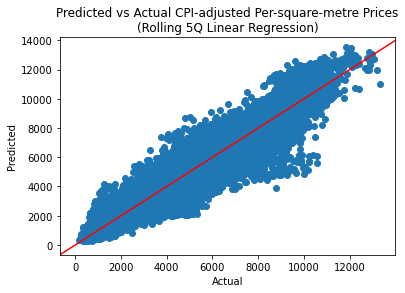

In [24]:
fig, ax = plt.subplots()
ax.axline((0, 0), slope=1, color="red")
plt.scatter(np.exp(pred_table.actual), np.exp(pred_table.pred))
plt.title("Predicted vs Actual CPI-adjusted Per-square-metre Prices\n(Rolling 5Q Linear Regression)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()